In [1]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt
op.visualization.set_mpl_style()

################ Mercury intrusion simulation ################

### Creating a cubic network
# Number of pores by coordinates (this has 10x10x10)
Nx, Ny, Nz = 10, 10, 10
# Spacing (I'm guessing in meters)
Lc = 1e-4
# Pore network is created
pn = op.network.Cubic([Nx, Ny, Nz], spacing=Lc)
# Spheres (pores) and cylinders (throats) are specified as geometries
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
# Model is generated
pn.regenerate_models()
# Prints the model
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x23d1d4b5a90>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                   1000 / 1000
  3  throat.conns                                                  2700 / 2700
  4  pore.coordination_number                                      1000 / 1000
  5  pore.max_size                                                 1000 / 1000
  6  throat.spacing                                                2700 / 2700
  7  pore.seed                                                     1000 / 1000
  8  pore.diameter                                                 1000 / 1000
  9  throat.max_size                                               2700 / 2700
 10 

In [2]:
### Defining a phase
# Define the phase (with the pore network)
hg = op.phase.Mercury(network=pn)
# Add a model to define phase
hg.add_model(propname='throat.entry_pressure',
             model=op.models.physics.capillary_pressure.washburn)
hg.regenerate_models()
print(hg)


══════════════════════════════════════════════════════════════════════════════
phase_01 : <openpnm.phase.Mercury at 0x23d17312c30>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.temperature                                              1000 / 1000
  3  pore.pressure                                                 1000 / 1000
  4  throat.contact_angle                                          2700 / 2700
  5  pore.thermal_conductivity                                     1000 / 1000
  6  pore.surface_tension                                          1000 / 1000
  7  pore.viscosity                                                1000 / 1000
  8  pore.density                                                  1000 / 1000
  9  pore.molar_density                                            1000 / 1000

In [3]:
### Performing a drainage simulation
# Pre-defined algorithm for drainage
mip = op.algorithms.Drainage(network=pn, phase=hg)
# Define boundary conditions for pressure
mip.set_inlet_BC(pores=pn.pores(['left', 'right']))
# Run simulation
mip.run(pressures=np.logspace(4, 6))

Performing drainage simulation:   0%|          | 0/50 [00:00<?, ?it/s]

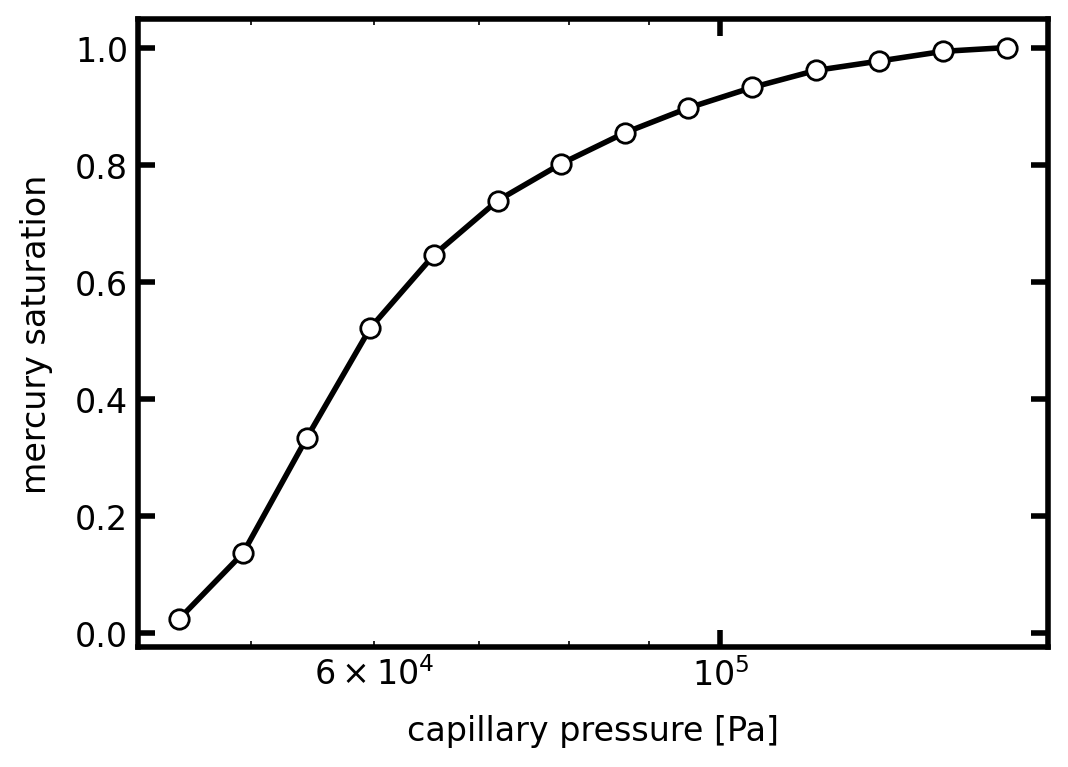

In [4]:
# Visualize data
data = mip.pc_curve()
fig, ax = plt.subplots(figsize=(5.5, 4))
ax.semilogx(data.pc, data.snwp, 'k-o')
ax.set_xlabel('capillary pressure [Pa]')
ax.set_ylabel('mercury saturation');

In [5]:
################ Calculating Permeability Coefficient ################

# Generate phase and physics
water = op.phase.Water(network=pn)
water.add_model(propname='throat.hydraulic_conductance',
                model=op.models.physics.hydraulic_conductance.generic_hydraulic)

# Create algorithm, set boundary conditions and run simulation
sf = op.algorithms.StokesFlow(network=pn, phase=water)
Pin, Pout = (200_000, 101_325)
sf.set_value_BC(pores=pn.pores('left'), values=Pin)
sf.set_value_BC(pores=pn.pores('right'), values=Pout)
sf.run()

In [6]:
# Permeability can be found using Darcy's law
Q = sf.rate(pores=pn.pores('left'))
A = Ny*Nz*Lc**2
L = Nx*Lc
mu = water['pore.viscosity'].mean()
K = Q*mu*L/(A*(Pin-Pout))
print(K)

[6.7335169e-13]


In [7]:
################ Adjusting Pore Size Distribution ################

# Geo object controlsgeometric properties
import openpnm.models.geometry as gmods

# Get old diameter to compare
pn['pore.old_diameter'] = pn.pop('pore.diameter')

# PSD from Weibull distribution where shape = 0.5 and scale = 1e-5
pn.add_model(propname='pore.diameter',
             model=gmods.pore_size.weibull,
             shape=0.5, loc=0, scale=1e-5)


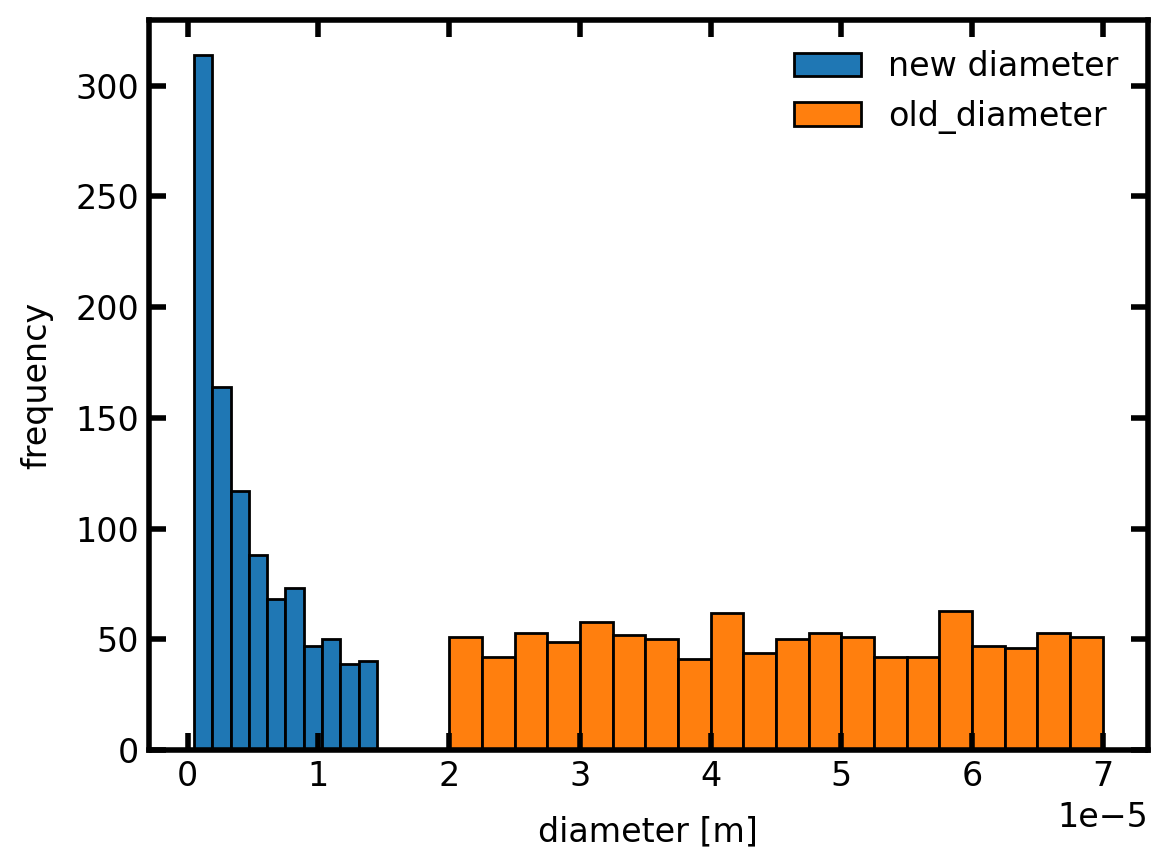

In [8]:
# Visualize PSD

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.hist(pn['pore.diameter'], edgecolor='k', label='new diameter')
ax.hist(pn['pore.old_diameter'], edgecolor='k', label='old_diameter', bins=20)
ax.set_xlabel('diameter [m]')
ax.set_ylabel('frequency')
ax.legend();